# First Analysis of the Experiment Data

In [1]:
import numpy as np
import pandas as pd
import collections, os, sys, random, time, pickle, dill, copy, re
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from tf.fabric import Fabric
from tf.extra.bhsa import Bhsa
from project_code.experiments2 import Experiment
from project_code.semspace import SemSpace

bhsa_data_paths=['~/github/etcbc/bhsa/tf/c',
                 '~/github/verb_semantics/project_code/lingo/heads/tf/c',
                 '~/github/verb_semantics/project_code/sdbh']

TF = Fabric(bhsa_data_paths)
tf_api = TF.load('''
                function lex lex_utf8 vs language
                pdp freq_lex gloss domain ls
                mother rela typ sp st code txt instruction
                heads prep_obj 
                prs prs_gn prs_nu prs_ps
                sem_domain sem_domain_code
              ''', silent=True)

tf_api.makeAvailableIn(globals())
B = Bhsa(api=tf_api, name='', version='c')

This is Text-Fabric 5.3.3
Api reference : https://dans-labs.github.io/text-fabric/Api/General/
Tutorial      : https://github.com/Dans-labs/text-fabric/blob/master/docs/tutorial.ipynb
Example data  : https://github.com/Dans-labs/text-fabric-data

118 features found and 0 ignored


**Documentation:** <a target="_blank" href="https://etcbc.github.io/bhsa" title="{provenance of this corpus}">BHSA</a> <a target="_blank" href="https://etcbc.github.io/bhsa/features/hebrew/c/0_home.html" title="{CORPUS.upper()} feature documentation">Feature docs</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/Bhsa/" title="BHSA API documentation">BHSA API</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/General/" title="text-fabric-api">Text-Fabric API 5.3.3</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/General/#search-templates" title="Search Templates Introduction and Reference">Search Reference</a>

In [2]:
print('Loading cached experiments...')
with open('/Users/cody/Documents/experiments.dill', 'rb') as infile:
    experiments = dill.load(infile)
    print(f'{len(experiments)} experiments loaded.')

Loading cached experiments...
50 experiments loaded.


In [3]:
print('Loading semantic space data: adjusting counts with pmi, preparing plotter functions, etc...')

spaces = dict((exp_name, SemSpace(exp, info=False)) for exp_name, exp in experiments.items())

print(f'{len(spaces)} experiments successfully loaded into semantic spaces.')

Loading semantic space data: adjusting counts with pmi, preparing plotter functions, etc...
50 experiments successfully loaded into semantic spaces.


## Experiments and their Shapes

In [4]:
for shape, exp in sorted((experiments[exp].data.shape, exp) for exp in experiments):
    print(f'{exp}:\t{shape}')

vi_subj_animacy:	(2, 180)
vi_allarg_pa:	(2, 694)
vi_objc_pa:	(2, 714)
vi_adj+_pa:	(2, 734)
vi_cmpl_pa:	(2, 734)
vi_coad_pa:	(2, 734)
vf_obj_pa:	(3, 694)
vd_domain_simple:	(3, 704)
vf_cmpl_pa:	(4, 725)
vi_objc_animacy:	(5, 173)
vf_adju_pa:	(7, 733)
vf_obj_animacy:	(8, 127)
vf_coad_pa:	(8, 734)
vg_tense:	(8, 734)
vi_cmpl_animacy:	(39, 174)
vf_argAll_pa:	(43, 703)
vi_adj+_animacy:	(46, 108)
vi_coad_animacy:	(51, 241)
vd_domain_embed:	(73, 646)
vf_cmpl_animacy:	(88, 158)
vi_allarg_animacy:	(92, 370)
vf_adju_animacy:	(96, 78)
vf_coad_animacy:	(200, 192)
vi_subj_domain:	(247, 231)
vd_par_lex:	(305, 365)
vf_argAll_animacy:	(378, 207)
vi_objc_domain:	(448, 245)
vf_obj_domain:	(584, 213)
vi_cmpl_domain:	(1033, 223)
vf_cmpl_domain:	(1128, 207)
vi_adj+_domain:	(1219, 217)
vf_adju_domain:	(1575, 180)
vi_coad_domain:	(1735, 386)
vi_subj_lex:	(1959, 290)
vi_objc_lex:	(2251, 305)
vi_allarg_domain:	(2902, 527)
vf_obj_lex:	(3012, 274)
vf_coad_domain:	(3055, 301)
vi_adj+_lex:	(3478, 295)
vf_cmpl_lex:	(4

## Deriving a Verb Specimen Set

Which verbs will comprise this study? This depends on which verbs are accounted for in the dataset. The presence/absence (pa) experiments count the most basic features, namely, the simple presence or absence of a given verbal argument: objects, complements, adjuncts. I will first try to derive a specimen set by taking the intersection of all the pa experiments.

In [5]:
specimens = set(experiments['vi_objc_pa'].data.columns)
print(f'Starting with specimens count of {len(specimens)}')

for exp_name, experiment in experiments.items():
    
    if not re.match('.*_pa', exp_name): # skip first pa experiments or non-pa exps.
        continue
        
    exp_lexemes = set(experiment.data.columns)
    specimens = exp_lexemes & specimens
    
print(f'Complete with specimen count of {len(specimens)}')

Starting with specimens count of 714
Complete with specimen count of 292


### Count Lexemes without Stems

All verbs have their stem appended. How many plain lexemes are in the specimen set?

In [6]:
plain_lexs = set(lex.split('.')[0] for lex in specimens)
lex_nodes = [(next(l for l in F.otype.s('lex') if F.lex.v(l) == lex),) for lex in plain_lexs]

print(f'Number of plain lexemes accounted for: {len(plain_lexs)}\n')
B.show(lex_nodes)

Number of plain lexemes accounted for: 238



We have a good and diverse dataset here. Let's see what the makeup of stems are.

### Stem Counts

In [7]:
stem_counts = collections.Counter(lex.split('.')[1] for lex in specimens)

stem_counts.most_common()

[('qal', 165),
 ('hif', 57),
 ('piel', 40),
 ('nif', 24),
 ('hit', 4),
 ('hsht', 1),
 ('hof', 1)]

## Coverage of Specimens throughout the Experiments

There are 297 verb specimens present with 243 plain lexical forms. Note that many of the experiments have different numbers of specimens present, due to the various requirements per experiment. We intend to use as much data as is present to inform the verb clustering. But are there some verbs whose coverage throughout all 50 experiments is especially lacking?

Below we count per lexeme how many different experiments it occurs in. The number itself is then counted.

In [8]:
spread_count = collections.Counter()
accounted_exps = set()

for lex in specimens:
    count = 0
    for exp_name, exp in experiments.items():
        if lex in exp.data.columns:
            count += 1
            accounted_exps.add(exp_name)
    spread_count[count] += 1
    
spread_count.most_common()

[(50, 26),
 (17, 14),
 (48, 14),
 (25, 13),
 (44, 13),
 (41, 12),
 (21, 11),
 (19, 11),
 (40, 11),
 (49, 10),
 (42, 10),
 (18, 10),
 (32, 10),
 (29, 9),
 (37, 8),
 (23, 8),
 (39, 8),
 (34, 8),
 (22, 7),
 (36, 7),
 (33, 7),
 (46, 7),
 (24, 6),
 (31, 6),
 (30, 6),
 (26, 5),
 (47, 5),
 (43, 5),
 (27, 5),
 (38, 4),
 (45, 4),
 (20, 4),
 (35, 3),
 (28, 2),
 (16, 2),
 (15, 1)]

What is the lowest accounted-for lexemes and how many of them are there?

In [9]:
min(spread_count.most_common())

(15, 1)

In [10]:
sum([amount for count, amount in spread_count.most_common() if count<20])

38

In [11]:
43/297 # ratio of total specimens within 20 or less experiments

0.1447811447811448

Only 1 lexeme is accounted for in only 15 of the experiments. 43 of the 297 verb specimens (14%) have less than 20 applicable experiments. These are acceptable amounts. Verbs that do not have an attested object, for instance, will not appear in 3 of 4 object experiments. But they *will* occur in the presence/absence object experiment. So it can be expected that certain verbs will be less accounted-for in various experiments.

## First Similarity Analysis

For each specimen, calculate its similarity with all other specimens pairwise based on all experiments which they have in common. The similarity scores will be averaged across all of the shared experiments. All raw counts have been adjusted using the pointwise mutual information (pmi) score. 

In [12]:
sim_matrix = pd.DataFrame(np.zeros(shape=(len(specimens), len(specimens))), columns=specimens, index=specimens) # for pairwise similarities
common_matrix = pd.DataFrame(np.zeros(shape=(len(specimens), len(specimens))), columns=specimens, index=specimens) # for counting number of common experiments

for lex in specimens:
    for space_name, space in spaces.items():
        
        if lex not in space.sim_pmi_nogloss.columns:
            continue
        
        sim_matrix[lex] = sim_matrix[lex].add(space.sim_pmi_nogloss[lex], fill_value=0)
        common_matrix[lex] += 1
        
sim = sim_matrix / common_matrix

In [13]:
#list(sim.columns)

In [14]:
sim['PYH[.qal']['PTX[.qal']

0.033968472930099095

In [111]:
sim['HJH[.qal'].sort_values(ascending=False).head(10)

HJH[.qal    1.000000
NTN[.qal    0.393290
<FH[.qal    0.377872
BW>[.qal    0.375166
JCB[.qal    0.352647
JY>[.qal    0.346812
CWB[.qal    0.342481
<LH[.qal    0.341883
NPL[.qal    0.330019
>MR[.qal    0.328523
Name: HJH[.qal, dtype: float64

### Looking at Surprise Word Similarities

One of the major goals of this project is to determine how verb meanings and classes are naturally distinguished by their context. היה is an interesting case of a verb which likely has no exact synonyms, but which exhibits similarity across all averaged experiments with words that are seemingly unsimilar such as נתן, עשה, בוא, etc. (see above). The purpose of gathering various kinds of contexts via the experiment parameters is to discover which contexts in particular are similar or different in various kinds of verbs. In this case, I want to know how the similarities of נתן and היה compare with words that are intuitively more similar to נתן such as שׂים and לקח, both of which are included in the top 10 similar terms to נתן along with היה (see below). For this, I will create a visualization that will allow me to visually compare the patterns of similarity between two given words amongst the various experiments. This will be a barchart with all similarity ratings from all the various parameters. The bars should be color-coded and logically grouped so that relevant patterns can be easily identified. This will hopefully allow me to observe where the key differences are between words with intuitive similarity and words without. It might also help determine why certain words are unintuitively rated as more similar than others.

In [250]:
sim['NTN[.qal'].sort_values(ascending=False).head(10)

NTN[.qal    1.000000
<FH[.qal    0.442549
FJM[.qal    0.421266
BW>[.hif    0.416374
LQX[.qal    0.414786
HJH[.qal    0.393290
NF>[.qal    0.372069
QR>[.qal    0.371095
CLX[.qal    0.353100
>MR[.qal    0.348045
Name: NTN[.qal, dtype: float64

#### Deriving A Plot Arrangement

The arrangment of experiment parameters on the plot is important, since I hope to use it to identify patterns. So here I develop an ordering and color scheme to be used with all of the plots.

##### Concept: Develop an ordering scheme based on specificity of parameters
I can attempt to arrange elements from more to less specific parameters. An example of a "specific" parameter would be one with lexical arguments, while a "general" parameter might only count the presence or absence of a given argument. Below is a concept of priorities:

1. verb grammar (vg)
    1. verb tense
2. verb domain (vd)
    1. simple domain
    2. embedded domain
    3. context clause chain
    4. context clause
    5. parallelism
    6. context window
3. verb inventories (allargs, adjunct, complement, object)
    1. presence
    2. animacy
    3. domain
    4. lexemes
4. verb frames
    1. same order as verb inventories

In [249]:
verb_grammar = ['vg_tense']

verb_domain = '''
vd_domain_simple
vd_domain_embed
vd_con_chain
vd_con_clause
vd_par_lex
vd_con_window
'''.strip().split('\n')

verb_inventories = '''
vi_subj_animacy
vi_subj_domain
vi_allarg_pa
vi_coad_pa
vi_adj+_pa
vi_cmpl_pa
vi_objc_pa
vi_allarg_animacy
vi_coad_animacy
vi_adj+_animacy
vi_cmpl_animacy
vi_objc_animacy
vi_allarg_domain
vi_coad_domain
vi_adj+_domain
vi_cmpl_domain
vi_objc_domain
vi_allarg_lex
vi_coad_lex
vi_subj_lex
vi_adj+_lex
vi_cmpl_lex
vi_objc_lex
'''.strip().split('\n')

verb_frames = '''
vf_argAll_pa
vf_coad_pa
vf_adju_pa
vf_cmpl_pa
vf_obj_pa
vf_argAll_animacy
vf_coad_animacy
vf_adju_animacy
vf_cmpl_animacy
vf_obj_animacy
vf_argAll_domain
vf_coad_domain
vf_adju_domain
vf_cmpl_domain
vf_obj_domain
vf_argAll_lex
vf_coad_lex
vf_adju_lex
vf_cmpl_lex
vf_obj_lex
'''.strip().split('\n')

# map experiment groups to colors
color2experiment = (('gold', verb_grammar),
                    (sns.color_palette(palette='Blues')[4], verb_inventories), 
                    (sns.color_palette(palette='Reds')[3], verb_frames))

# make ordered tuple of colors
expcolors = tuple(color for color, exp_list in color2experiment # make tuple of colors
                        for exp in exp_list) 

# ordered tuple of experiments 
exporder = tuple(exp for color, exp_list in color2experiment
                    for exp in exp_list)

In [437]:
def get_sim_experiments(lex1, lex2, order=exporder, colors=expcolors, show=True, returnData=True):
    '''
    Exports a barchart that illustrates the leveldi
    of similarity between two lexemes per all experiments
    in the dataset.
    '''
    
    sims = dict() # temporarily hold similarity scores here
    
    # gather rated similarities between the two terms for every provided experiment
    for sp_name, space in spaces.items():
        
        if not {lex1, lex2} & set(space.sim_pmi_nogloss.columns): # ensure both terms are in the space
            continue
            
        sims[sp_name] = space.sim_pmi_nogloss[lex1][lex2] # get similarity
        
    sims_ordered = collections.OrderedDict((exp, sims[exp]) for exp in order if exp in sims) # customized order
    sims = pd.DataFrame(list(sims_ordered.items())) # drop into Dataframe
    sims.columns = ['experiment', 'score'] # set col names
    
    if show:
        # plot:
        plt.figure(figsize=(10, 15)) 
        sns.barplot(sims['score'], sims['experiment'],  palette=colors, orient='h')
        plt.yticks(fontsize=12)
        plt.ylabel('experiment', fontsize=18)
        plt.xlabel('similarity score', fontsize=18)
        plt.title(f'Scored Similarities between {lex1} and {lex2}', fontsize=20)
        
    if returnData:
        return sims

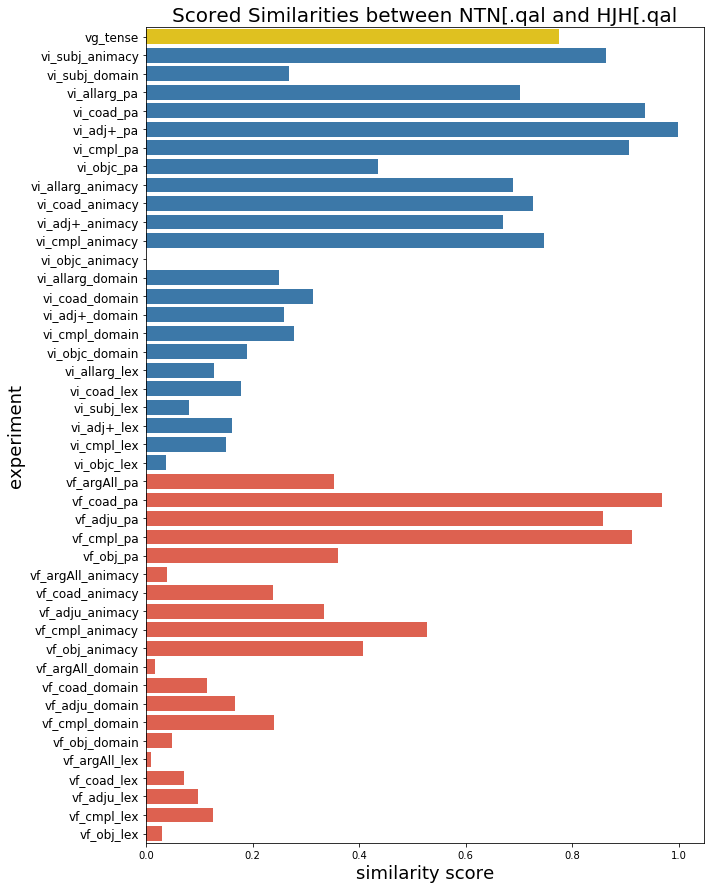

In [438]:
give_be = get_sim_experiments('NTN[.qal', 'HJH[.qal')

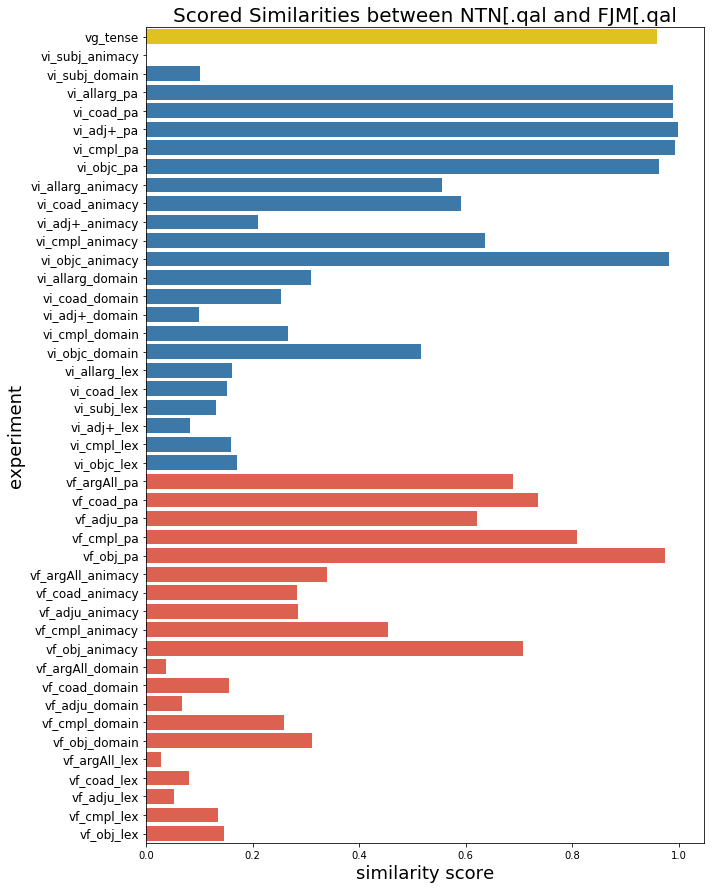

In [439]:
give_set = get_sim_experiments('NTN[.qal', 'FJM[.qal')

In [449]:
def compare_simPatterns(dataset1, dataset2, pairs='', colors=expcolors):
    '''
    Compare barchart similarity patterns accross two barcharts.
    The first dataset is the primary dataset and will be colored
    normally. The second dataset will be colored grey for comparison.
    '''
    
    data1Sims = list(reversed(dataset1['score']))
    data2Sims = list(reversed(dataset2['score']))
    xLocations = np.arange(dataset1.shape[0])
    barwidth = 0.8       # the width of the bars: can also be len(x) sequence
    plt.figure(figsize=(10, 15)) 
    p1 = plt.barh(xLocations, data1Sims, barwidth, color=sns.color_palette(palette='Reds')[3])
    p2 = plt.barh(xLocations, data2Sims, barwidth, color=sns.color_palette(palette='Blues')[4])
    plt.yticks(xLocations, list(reversed(dataset1['experiment'])), fontsize=12)
    
    plt.ylabel('experiment', fontsize=18)
    plt.xlabel('similarity score', fontsize=18)
    plt.title(f'Similarity Differences between {pairs[0]} and {pairs[1]}', fontsize=20)
    
    plt.legend((p1[0], p2[0]), (f'{pairs[0]}', f'{pairs[1]}'), fontsize=12)
    
def compareSets(set1, set2):
    '''
    Compare two pairs of words and their similarity differences.
    '''
    dataset1 = get_sim_experiments(set1[0], set1[1], show=False)
    dataset2 = get_sim_experiments(set2[0], set2[1], show=False)
    
    compare_simPatterns(dataset1, dataset2, pairs=(f'{set1[0]} & {set1[1]}', f'{set2[0]} & {set2[1]}'))

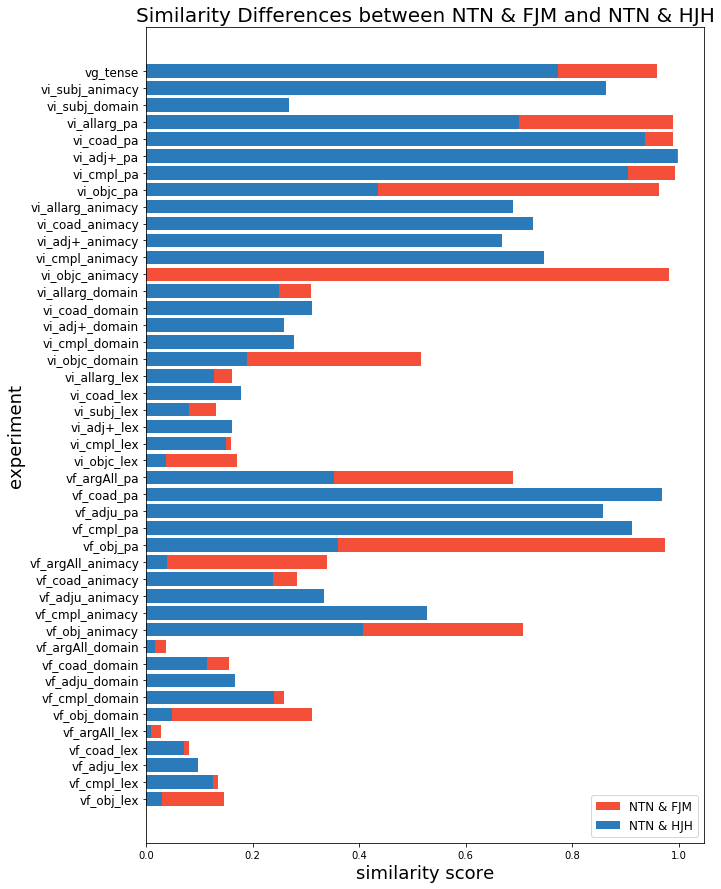

In [450]:
compare_simPatterns(give_set, give_be, pairs=['NTN & FJM', 'NTN & HJH'])

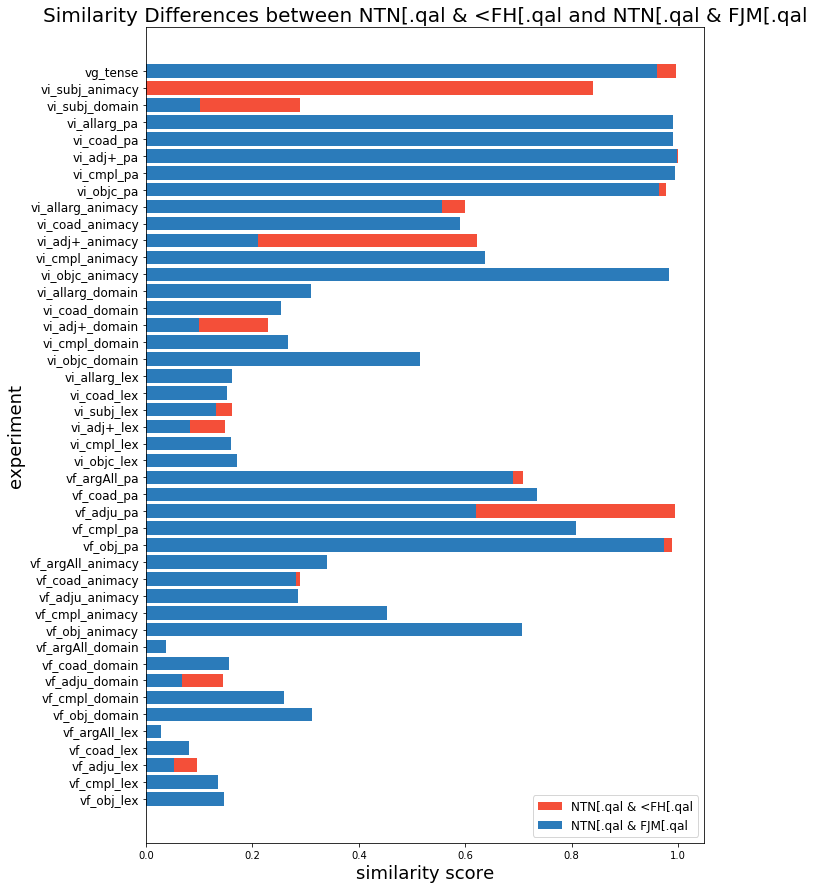

In [451]:
compareSets(('NTN[.qal', '<FH[.qal'), ('NTN[.qal', 'FJM[.qal'))

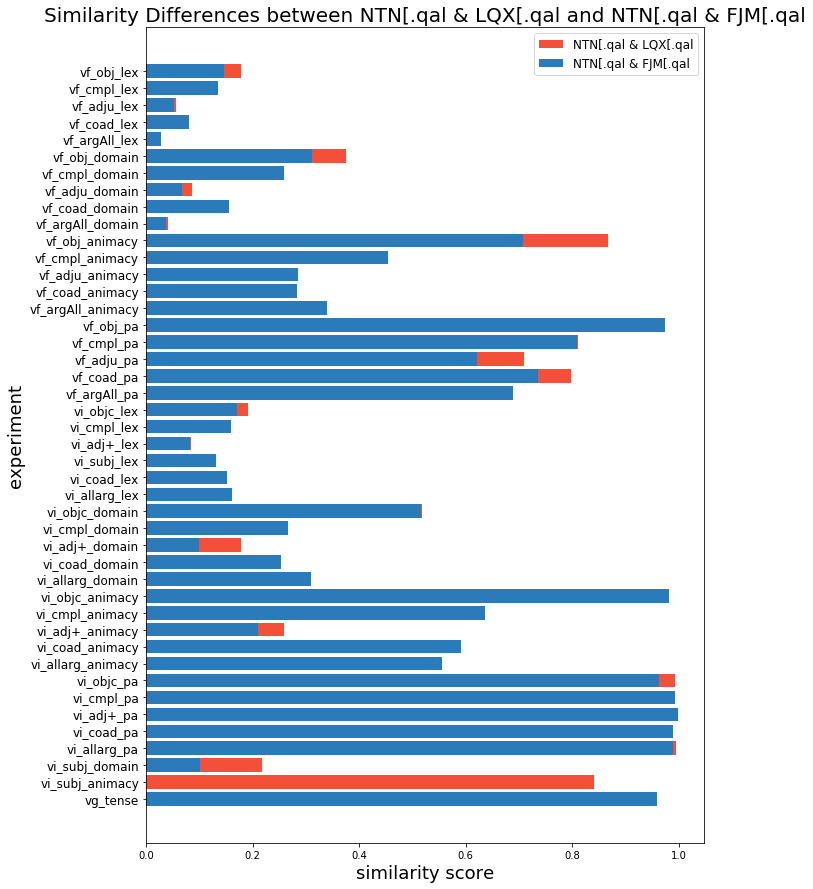

In [421]:
compareSets(('NTN[.qal', 'LQX[.qal'), ('NTN[.qal', 'FJM[.qal'))

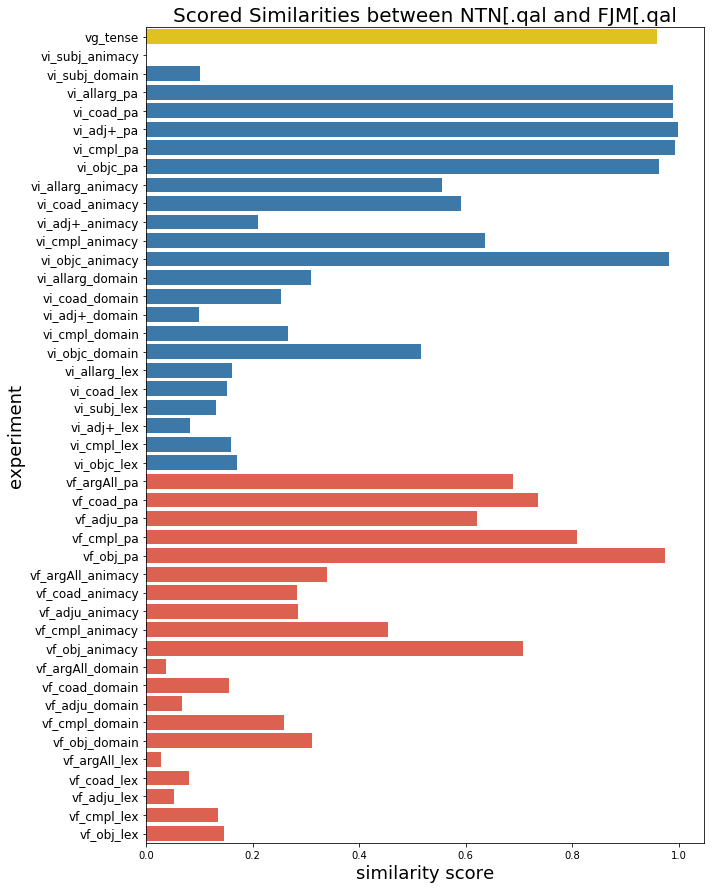

In [452]:
get_sim_experiments('NTN[.qal', 'FJM[.qal', returnData=False)

## Examining Distributions of Presence/Absence Inventory Experiments

Presence/absence experiments test whether and how often a given verb occurs with a given argument. Each experiment tests a single argument or combined set of arguments. These are: objects, complements, adjuncts, complements + adjuncts, and all arguments. For each argument type, there is a simple binary variable: present or not. Below we normalize across verbs to observe the distribution of verbs with the given argument.

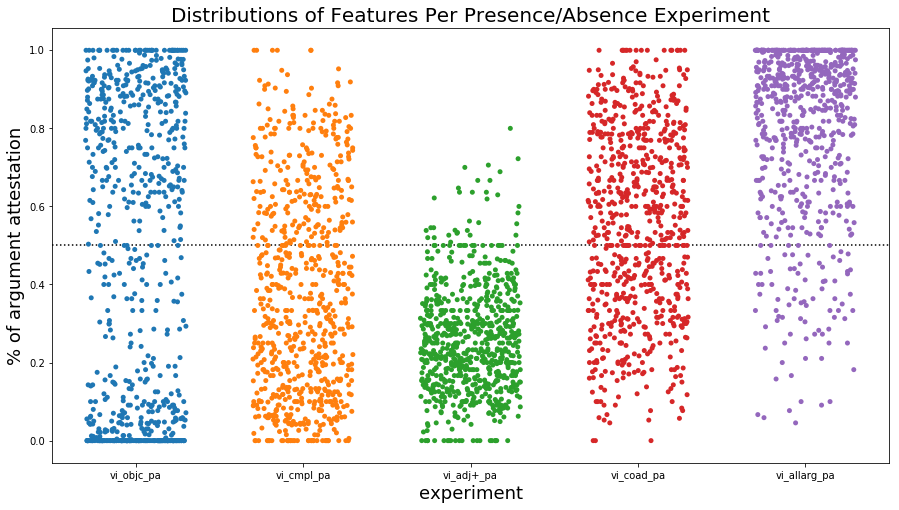

In [22]:
vi_datas = pd.DataFrame((experiments['vi_objc_pa'].data / experiments['vi_objc_pa'].data.sum()).loc['Objc']) # normalized objc data
vi_datas.columns = ('ratio of attestation',)
vi_datas['experiment'] = 'vi_objc_pa'

for exp_name, experiment in experiments.items():
    
    if exp_name == 'vi_objc_pa' or not re.match('vi_.*_pa', exp_name): # skip any non-pa experiments
        continue
        
    exp = experiment.data / experiment.data.sum() # normalize

    arg = next(i for i in exp.index if i != 'ø')
    
    datas = pd.DataFrame(exp.loc[arg])
    datas.columns = ('ratio of attestation',)
    datas['experiment'] = exp_name
    
    vi_datas = pd.concat((vi_datas, datas))

plt.figure(figsize=(15,8))
plt.title('Distributions of Features Per Presence/Absence Experiment', fontsize=20)
sns.stripplot(x='experiment', y='ratio of attestation', data=vi_datas, jitter=0.3)
plt.xlabel('experiment', fontsize=18)
plt.ylabel('% of argument attestation', fontsize=18)
plt.axhline(0.5, color='black', linestyle='dotted')

### Initial Observations

The combined, complement + adjunct experiment seems to have the most even distribution of features. The object presence/absence experiment appears to show the most separation between verbs. The adjunct tends to have <50% attestation, while the opposite is true for the allarg experiment.

It is possible to venture a few generalizations based on this visual:

* Verbs appear to exhibit a more even polarity between the presence/absence of an object argument.
* The number of verbs that occur with or without a complementizer appear to be fairly balanced, with a slight preference for <50% of those verbs' occurrences having a complement.
* There are more verbs with ≤50% of adjunct elements.
* The number of verbs with a higher proportion of complement or adjunct arguments is seems evenly distributed, with a slight preference for >50%.
* The number of verbs with a proportion >50% of any of the arguments appears to be high. 

#### Number of Verbs with 100% or 0% Objc

In [23]:
ratioedO = experiments['vi_objc_pa'].data / experiments['vi_objc_pa'].data.sum()
allO = ratioedO.loc['Objc'][ratioedO.loc['Objc'] == 1.0]
noO = ratioedO.loc['Objc'][ratioedO.loc['ø'] == 1.0]

print(f'{allO.shape[0]} verbs that have an object 100% of the time...')
print(f'{noO.shape[0]} verbs that never occur with an object...')

39 verbs that have an object 100% of the time...
148 verbs that never occur with an object...


#####  Verbs with 100% Objects

In [24]:
print(' | '.join(allO.index))

<WR[.piel | B<T[.piel | BR>[.qal | BXN[.qal | CBH[.qal | CBR[.piel | CLL[.qal | CWB=[.qal | DK>[.piel | FB<[.hif | FMX[.piel | GRC[.piel | JYT[.hif | KN<[.hif | KRH[.qal | LBC[.hif | LXY[.qal | N>Y[.piel | NF>[.piel | NHG[.piel | NPY[.piel | NQB[.qal | NSK[.hif | NTQ[.piel | NXH[.hif | NXH[.qal | NYB[.hif | PQX[.qal | PYH[.qal | RJQ[.hif | RKB[.hif | SQL[.qal | SWT[.hif | XLH[.piel | XLY[.piel | XRB[.hif | YPH=[.piel | ZHR[.hif | ZRH[.piel


##### Verbs with 0% Objects

In [25]:
print(' | '.join(noO.index))

<LH[.nif | <LZ[.qal | <WP[.qal | <YM[.qal | <YR[.nif | >BD[.qal | >BL[.hit | >BL[.qal | >CM[.qal | >ML[.pual | >MY[.qal | >WR[.qal | BHL[.nif | BLH[.qal | BNH[.nif | BQ<[.nif | BRK[.qal | BRX[.qal | BW>[.hof | C<H[.qal | C<N[.nif | C>G[.qal | C>R[.nif | CDD[.pual | CKM[.hif | CKX[.nif | CLK[.hof | CM<[.nif | CMM[.nif | CMR[.nif | CNH[.qal | CPL[.qal | CQD[.qal | CQP[.hif | CRQ[.qal | CW<[.piel | CXX[.qal | DMH=[.nif | FRP[.nif | FXQ[.piel | FXQ[.qal | GBH[.qal | GW<[.qal | HJH[.nif | HLK[.piel | HLL[.hit | HMH[.qal | J<D[.nif | JBC[.qal | JCR[.qal | JD<[.nif | JG<[.qal | JLD[.nif | JLD[.pual | JLL[.hif | JQY[.qal | JR>[.nif | JTR[.nif | JVB[.qal | JXL[.hif | JYB[.hit | KBD[.nif | KBH[.qal | KCL[.nif | KCL[.qal | KLM[.nif | KN<[.nif | KR<[.qal | KTB[.nif | KWN[.nif | KXC[.piel | L<G[.qal | LKD[.nif | MKR[.nif | MLK[.qal | MLV[.nif | MSS[.nif | MWV[.nif | NBL[.qal | NF>[.nif | NGC[.nif | NGD[.hof | NGP[.nif | NPL[.qal | NQH[.nif | NTQ[.nif | NW<[.qal | NWD[.qal | NWX[.qal | NXM[.nif | NY

In [27]:
# B.show(B.search('''

# clause
#     phrase function=Pred
#         word lex=BW>[ vs=qal

#     phrase function=Objc
# '''))

BW> with objects is a good example of the shortcomings of the ETCBC "object" label, which does not sharply distinguish between "objects" and "complements." Note however the group of verbs just beneath the 20% marker in the strip chart. Are many of these motion verbs like BW>?

In [28]:
smallO = ratioedO.loc['Objc'][ratioedO.loc['Objc'] <= 0.20]
print(f'{smallO.shape[0]} verbs that have an object ≤20% of the time...')

289 verbs that have an object ≤20% of the time...


In [29]:
print(' | '.join(smallO.index))

<FH[.nif | <LH[.nif | <LH[.qal | <LZ[.qal | <MD[.qal | <WP[.qal | <WR[.qal | <YM[.qal | <YR[.nif | >BD[.qal | >BH[.qal | >BL[.hit | >BL[.qal | >CM[.qal | >KL[.nif | >ML[.pual | >MN[.hif | >MN[.nif | >MY[.qal | >NX[.nif | >RB[.qal | >SP[.nif | >TH[.qal | >WR[.qal | >XR[.piel | B<R[.qal | BGD[.qal | BHL[.nif | BKH[.qal | BLH[.qal | BLL[.qal | BNH[.nif | BQ<[.nif | BRK[.qal | BRX[.qal | BVX[.qal | BW>[.hof | BW>[.qal | BWC[.qal | BWZ[.qal | C<H[.qal | C<N[.nif | C>G[.qal | C>R[.nif | CB<[.nif | CBR[.nif | CBT[.qal | CDD[.pual | CGH[.qal | CKB[.qal | CKM[.hif | CKN[.qal | CKX[.nif | CLK[.hof | CM<[.nif | CMD[.nif | CMM[.nif | CMM[.qal | CMR[.nif | CNH[.qal | CPL[.qal | CQD[.qal | CQP[.hif | CQV[.qal | CRQ[.qal | CTL[.qal | CW<[.piel | CWB[.qal | CXX[.qal | DBQ[.qal | DMH=[.nif | DMH[.qal | DMM[.qal | FJX[.qal | FMX[.qal | FRP[.nif | FWF[.qal | FXQ[.piel | FXQ[.qal | GBH[.qal | GBR[.qal | GDL[.qal | GJL[.qal | GLH[.nif | GRH[.hit | GW<[.qal | GWR==[.qal | GWR[.qal | HJH[.nif | HJH[.qal | HL